# Prepare the data

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Load data & tokenize

In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}

print(len(words))
print(vocab_size)

32033
27


### Create a train/val/tast split

In [4]:
block_size = 6

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP

### Initialize parameters

In [5]:
embed_size = 10
hidden_size = 300

In [6]:
E = torch.randn((vocab_size, embed_size))       # 27 x 10
W1 = torch.randn((embed_size*block_size, hidden_size))  * (5/3) / ((embed_size*block_size)**0.5)
# b1 = torch.randn(hidden_size) * 0.01                          # 300
W2 = torch.randn((hidden_size, vocab_size)) * 0.01           # 300 x 27
b2 = torch.randn(vocab_size) * 0     #  27

bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
parameters = [E, W1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True

In [7]:
# Number of parameters in the model
params = sum(p.nelement() for p in parameters)
params

26997

# Training

In [8]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 100**lre

In [9]:
lri= []
lossi = []
stepi = []

In [11]:
max_steps = 200000
batch_size = 64
for _ in range(max_steps):
    
    ix = torch.randint(1, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = E[Xb]
    embcat = emb.view(emb.shape[0], -1)
    
    # Linear layer
    hpreact = embcat @ W1 #+ b1
    
    # -------- Bartch Norm Layer ------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = (hpreact.std(0, keepdim=True))
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    # ---------------------------------------------------------------------------------------------------    
 
    
    # Non-linear layer
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if _ < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lre[_])
    if _ % 10000 ==0:
        print(f'loss on {_} steps is: {loss.item()}')
    lossi.append(loss.log10().item())

    # break

loss on 0 steps is: 3.310346841812134
loss on 10000 steps is: 2.1362791061401367
loss on 20000 steps is: 2.0280137062072754
loss on 30000 steps is: 2.1979830265045166
loss on 40000 steps is: 2.1722028255462646
loss on 50000 steps is: 1.828978419303894
loss on 60000 steps is: 1.8126987218856812
loss on 70000 steps is: 1.8778479099273682
loss on 80000 steps is: 1.7615725994110107
loss on 90000 steps is: 2.2651162147521973
loss on 100000 steps is: 2.2451601028442383
loss on 110000 steps is: 2.0215516090393066
loss on 120000 steps is: 2.1025331020355225
loss on 130000 steps is: 1.8443973064422607
loss on 140000 steps is: 1.9162116050720215
loss on 150000 steps is: 1.9946939945220947
loss on 160000 steps is: 2.3167600631713867
loss on 170000 steps is: 2.117255210876465
loss on 180000 steps is: 1.8798859119415283
loss on 190000 steps is: 2.08978271484375


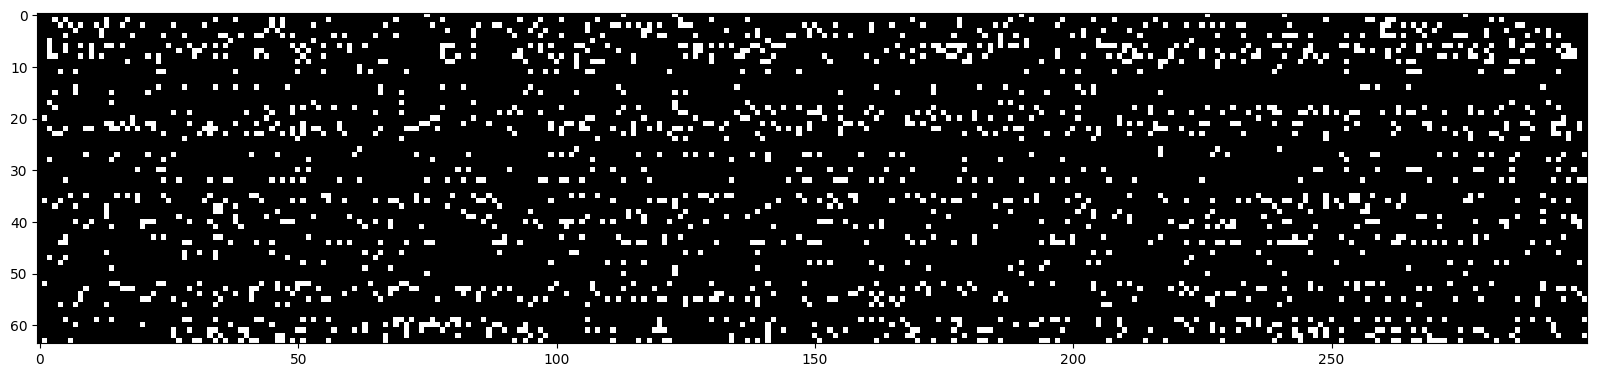

In [12]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > .99, cmap='grey', interpolation='nearest')

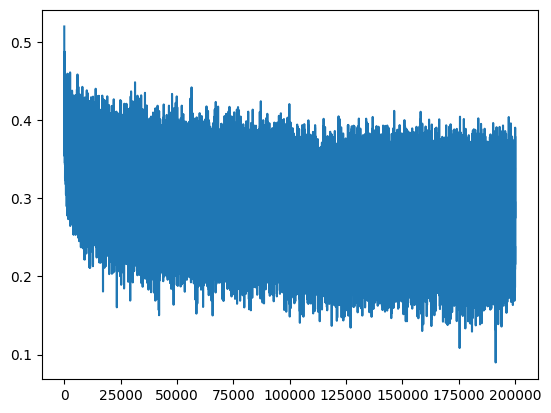

In [13]:
plt.plot(lossi)

In [12]:
with torch.no_grad():
    emb = E[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

### Evaluating loss

In [17]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = E[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias  
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split,  loss.item())
    
split_loss('train')
split_loss('val')
split_loss('test')
    

train 1.8663023710250854
val 2.009913921356201
test 2.010762929916382


# Sampling from the model

In [19]:
for i in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb1 = E[torch.tensor([context])]
        embcat = emb1.view(emb1.shape[0], -1)
        hpreact = embcat @ W1 
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias  
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix ==0:
            break
        
    print(''.join(itos[i] for i in out ))

kailah.
kyo.
mauri.
kwaida.
nellyn.
avalennin.
breyten.
aadvikut.
dabine.
khilee.
josselyn.
amaele.
layaz.
jana.
haelene.
ambrie.
kyri.
delvin.
klosly.
graysen.


## Pretty good))